# Урок 3. TensorFlow

## 1-2. (*) Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews. Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

### Эксперимент 1

In [61]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

import matplotlib.pyplot as plt

import os

import re

import string

import shutil

import numpy as np

In [2]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [3]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [4]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

In [5]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 21s 634ms/step - loss: 0.6689 - accuracy: 0.6008 - val_loss: 0.6089 - val_accuracy: 0.7214
Epoch 2/10
30/30 [==============================] - 19s 619ms/step - loss: 0.5307 - accuracy: 0.8000 - val_loss: 0.4830 - val_accuracy: 0.8118
Epoch 3/10
30/30 [==============================] - 19s 615ms/step - loss: 0.3883 - accuracy: 0.8667 - val_loss: 0.3893 - val_accuracy: 0.8450
Epoch 4/10
30/30 [==============================] - 19s 608ms/step - loss: 0.2791 - accuracy: 0.9086 - val_loss: 0.3376 - val_accuracy: 0.8610
Epoch 5/10
30/30 [==============================] - 19s 625ms/step - loss: 0.2018 - accuracy: 0.9383 - val_loss: 0.3154 - val_accuracy: 0.8696
Epoch 6/10
30/30 [==============================] - 19s 610ms/step - loss: 0.1475 - accuracy: 0.9599 - val_loss: 0.3061 - val_accuracy: 0.8736
Epoch 7/10
30/30 [==============================] - 19s 612ms/step - loss: 0.1075 - accuracy: 0.9747 - val_loss: 0.3073 - val_accuracy: 0.8735

In [8]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 5s - loss: 0.3657 - accuracy: 0.8545 - 5s/epoch - 96ms/step
loss: 0.366
accuracy: 0.855


In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

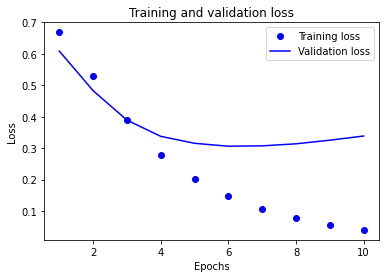

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

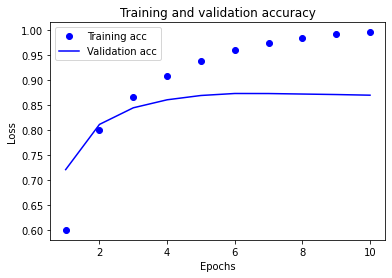

In [11]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Эксперимент 2

In [12]:
training_sentences = []
training_labels = []

validation_sentences = []
validation_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s,l in validation_data:
  validation_sentences.append(str(s.numpy()))
  validation_labels.append(l.numpy())

for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

In [15]:
training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)
testing_labels_final = np.array(testing_labels)

In [16]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [17]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(6,activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
  ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 11526     
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [19]:
num_epochs = 10
history = model.fit(training_padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 0.5808 - accuracy: 0.6715 - val_loss: 0.3961 - val_accuracy: 0.8230
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2630 - accuracy: 0.8969 - val_loss: 0.3820 - val_accuracy: 0.8351
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0884 - accuracy: 0.9803 - val_loss: 0.4395 - val_accuracy: 0.8257
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0219 - accuracy: 0.9980 - val_loss: 0.5020 - val_accuracy: 0.8216
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0069 - accuracy: 0.9997 - val_loss: 0.5409 - val_accuracy: 0.8236
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.5801 - val_accuracy: 0.8225
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.6110 - val_accuracy: 0.8235
Epoch 

In [20]:
results = model.evaluate(testing_padded, testing_labels_final, verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

782/782 - 1s - loss: 0.6600 - accuracy: 0.8246 - 906ms/epoch - 1ms/step
loss: 0.660
accuracy: 0.825


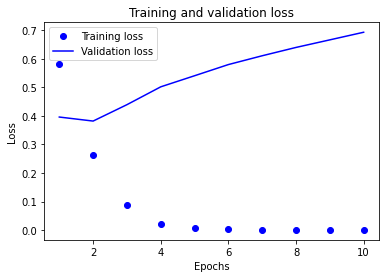

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

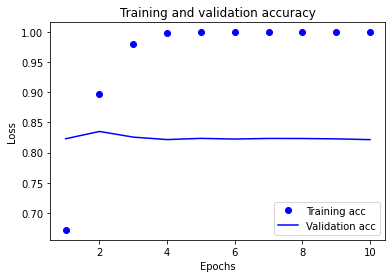

In [22]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Эксперимент 3

In [23]:
vocab_size = 1000
embedding_dim = 50
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [24]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(6,activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
  ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 50)           50000     
                                                                 
 flatten_1 (Flatten)         (None, 6000)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                 36006     
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 86,013
Trainable params: 86,013
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 10
history = model.fit(training_padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.5832 - accuracy: 0.6677 - val_loss: 0.4504 - val_accuracy: 0.7875
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3683 - accuracy: 0.8422 - val_loss: 0.4543 - val_accuracy: 0.7893
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2302 - accuracy: 0.9181 - val_loss: 0.5206 - val_accuracy: 0.7750
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1005 - accuracy: 0.9786 - val_loss: 0.6306 - val_accuracy: 0.7644
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0331 - accuracy: 0.9970 - val_loss: 0.7512 - val_accuracy: 0.7631
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0132 - accuracy: 0.9985 - val_loss: 0.8423 - val_accuracy: 0.7603
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 0.9242 - val_accuracy: 0.7608
Epoch 

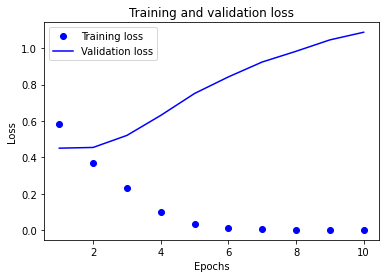

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

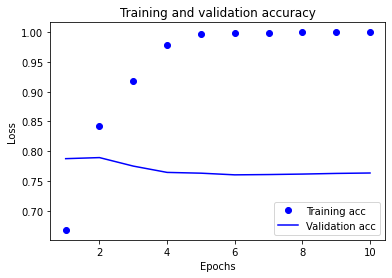

In [27]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Эксперимент 4

In [28]:
vocab_size = 100
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [29]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(6,activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
  ])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           1600      
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dense_6 (Dense)             (None, 6)                 11526     
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 13,133
Trainable params: 13,133
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 10
history = model.fit(training_padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6705 - accuracy: 0.5769 - val_loss: 0.6182 - val_accuracy: 0.6591
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.5891 - accuracy: 0.6869 - val_loss: 0.6192 - val_accuracy: 0.6550
Epoch 3/10
469/469 [==============================] - 2s 3ms/step - loss: 0.5583 - accuracy: 0.7092 - val_loss: 0.6067 - val_accuracy: 0.6761
Epoch 4/10
469/469 [==============================] - 2s 3ms/step - loss: 0.5361 - accuracy: 0.7328 - val_loss: 0.6421 - val_accuracy: 0.6551
Epoch 5/10
469/469 [==============================] - 2s 3ms/step - loss: 0.5164 - accuracy: 0.7462 - val_loss: 0.6369 - val_accuracy: 0.6588
Epoch 6/10
469/469 [==============================] - 2s 3ms/step - loss: 0.4986 - accuracy: 0.7549 - val_loss: 0.6546 - val_accuracy: 0.6509
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: 0.4777 - accuracy: 0.7734 - val_loss: 0.6779 - val_accuracy: 0.6375
Epoch 

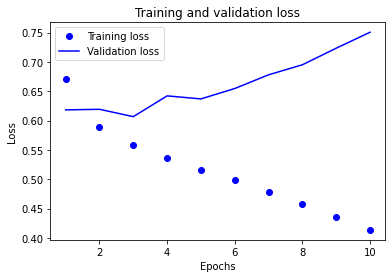

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

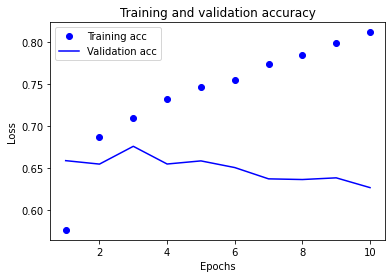

In [32]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Эксперимент 5

In [33]:
imdb, info = tfds.load("imdb_reviews",with_info=True, as_supervised = True)

In [34]:
train_data, test_data = imdb['train'], imdb['test']

In [35]:
training_sentences =[]
training_labels =[]

testing_sentences =[]
testing_labels =[]

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

len(training_sentences), len(testing_sentences)

(25000, 25000)

In [36]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [37]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten_3 (Flatten)         (None, 1920)              0         
                                                                 
 dense_8 (Dense)             (None, 6)                 11526     
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [39]:
num_epochs = 10
history = model.fit(padded, training_labels_final, 
          epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4981 - accuracy: 0.7428 - val_loss: 0.3443 - val_accuracy: 0.8507
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2537 - accuracy: 0.8974 - val_loss: 0.3613 - val_accuracy: 0.8412
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1195 - accuracy: 0.9646 - val_loss: 0.4412 - val_accuracy: 0.8252
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0377 - accuracy: 0.9942 - val_loss: 0.5124 - val_accuracy: 0.8265
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0159 - accuracy: 0.9978 - val_loss: 0.5679 - val_accuracy: 0.8266
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0085 - accuracy: 0.9986 - val_loss: 0.6244 - val_accuracy: 0.8216
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.7009 - val_accuracy: 0.8196
Epoch 

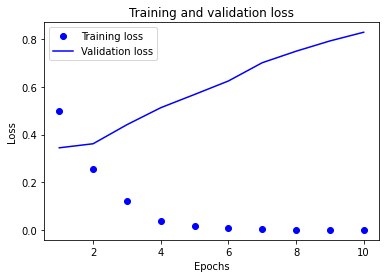

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

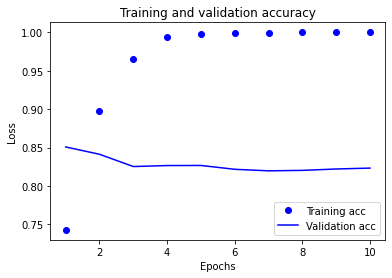

In [41]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Эксперимент 6

In [42]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [43]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_10 (Dense)            (None, 64)                3264      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 48,196,489
Trainable params: 48,196,489
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 20s 629ms/step - loss: 0.6371 - accuracy: 0.6567 - val_loss: 0.5449 - val_accuracy: 0.7499
Epoch 2/10
30/30 [==============================] - 19s 607ms/step - loss: 0.4282 - accuracy: 0.8167 - val_loss: 0.3747 - val_accuracy: 0.8359
Epoch 3/10
30/30 [==============================] - 19s 612ms/step - loss: 0.2482 - accuracy: 0.9023 - val_loss: 0.3362 - val_accuracy: 0.8590
Epoch 4/10
30/30 [==============================] - 19s 608ms/step - loss: 0.1423 - accuracy: 0.9523 - val_loss: 0.3435 - val_accuracy: 0.8664
Epoch 5/10
30/30 [==============================] - 19s 611ms/step - loss: 0.0725 - accuracy: 0.9803 - val_loss: 0.3814 - val_accuracy: 0.8667
Epoch 6/10
30/30 [==============================] - 19s 613ms/step - loss: 0.0345 - accuracy: 0.9933 - val_loss: 0.4479 - val_accuracy: 0.8632
Epoch 7/10
30/30 [==============================] - 19s 608ms/step - loss: 0.0157 - accuracy: 0.9985 - val_loss: 0.4894 - val_accuracy: 0.8623

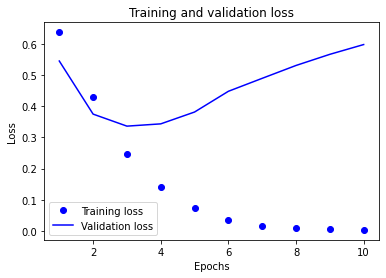

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

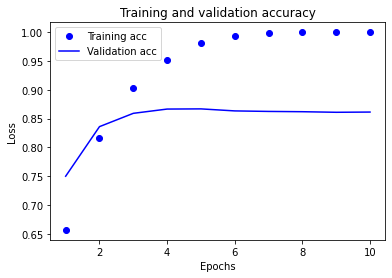

In [46]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Эксперимент 7

In [47]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_14 (Dense)            (None, 64)                3264      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 48,196,489
Trainable params: 48,196,489
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(train_data.shuffle(1000).batch(256),
                    epochs=5,
                    validation_data=validation_data.batch(256),
                    verbose=1)

Epoch 1/5
59/59 [==============================] - 36s 597ms/step - loss: 0.6274 - accuracy: 0.6775 - val_loss: 0.4839 - val_accuracy: 0.7895
Epoch 2/5
59/59 [==============================] - 35s 588ms/step - loss: 0.3361 - accuracy: 0.8609 - val_loss: 0.3260 - val_accuracy: 0.8624
Epoch 3/5
59/59 [==============================] - 35s 591ms/step - loss: 0.1762 - accuracy: 0.9359 - val_loss: 0.3397 - val_accuracy: 0.8672
Epoch 4/5
59/59 [==============================] - 35s 595ms/step - loss: 0.0864 - accuracy: 0.9733 - val_loss: 0.4006 - val_accuracy: 0.8602
Epoch 5/5
59/59 [==============================] - 35s 591ms/step - loss: 0.0383 - accuracy: 0.9913 - val_loss: 0.4430 - val_accuracy: 0.8664


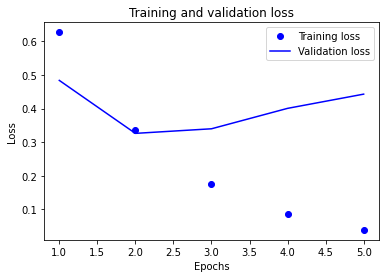

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

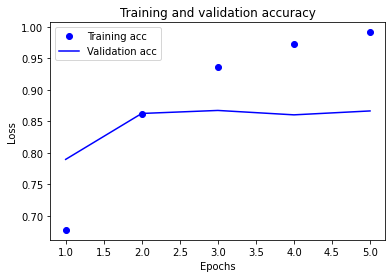

In [50]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Эксперимент 8

In [51]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['README', 'imdbEr.txt', 'test', 'imdb.vocab', 'train']

In [52]:
train_dir = os.path.join(dataset_dir, 'train')

os.listdir(train_dir)

['neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_unsup.txt',
 'unsup',
 'pos']

In [53]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [54]:
batch_size = 1024
seed = 123
train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [56]:
embedding_layer = tf.keras.layers.Embedding(1000, 5)

In [57]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [62]:
embedding_dim=16

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-tr

In [63]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[tensorboard_callback])

Epoch 1/30
20/20 [==============================] - 3s 134ms/step - loss: 0.6917 - accuracy: 0.5028 - val_loss: 0.6895 - val_accuracy: 0.4886
Epoch 2/30
20/20 [==============================] - 2s 78ms/step - loss: 0.6864 - accuracy: 0.5028 - val_loss: 0.6826 - val_accuracy: 0.4886
Epoch 3/30
20/20 [==============================] - 2s 82ms/step - loss: 0.6771 - accuracy: 0.5028 - val_loss: 0.6713 - val_accuracy: 0.4886
Epoch 4/30
20/20 [==============================] - 2s 80ms/step - loss: 0.6627 - accuracy: 0.5028 - val_loss: 0.6549 - val_accuracy: 0.4886
Epoch 5/30
20/20 [==============================] - 2s 81ms/step - loss: 0.6424 - accuracy: 0.5031 - val_loss: 0.6332 - val_accuracy: 0.4908
Epoch 6/30
20/20 [==============================] - 2s 79ms/step - loss: 0.6164 - accuracy: 0.5383 - val_loss: 0.6071 - val_accuracy: 0.5572
Epoch 7/30
20/20 [==============================] - 2s 81ms/step - loss: 0.5855 - accuracy: 0.6148 - val_loss: 0.5779 - val_accuracy: 0.6264
Epoch 8/30
2

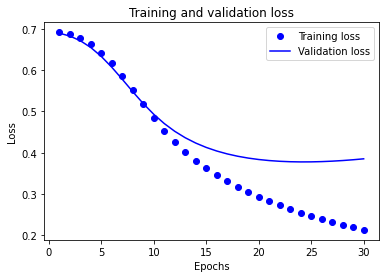

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

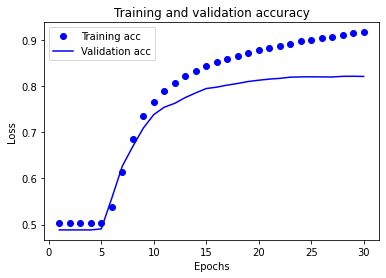

In [65]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [70]:
%reload_ext tensorboard
%tensorboard --logdir logs

/bin/bash: line 0: kill: (10027) - No such process


Reusing TensorBoard on port 6006 (pid 10027), started 0:59:46 ago. (Use '!kill 10027' to kill it.)

<IPython.core.display.Javascript object>

### Выводы

- задачи со звездочками мне решать рано, но было интересней выполнить что-то новое, нежели повторять действия, продемонстрированные на вебинаре;
- очень многое остается непонятным (как выбирать размер входного слоя; какие гиперпараметры еще доступны для улучшения работы нейросети; как пользоваться эмбедингом; почему графики, похожие на графики, которые можно улучшать получились только в учебном эксперименте 1, который был найден в интернете, а в экспериментах 6 и 7 только ухудшались; почему полное копирование учебного примера в эксперименте 8 совсем не приблизило к желаемому результату; когда используются массивы нумпай, а когда тензоры и работа с размерностью);
- надо учиться структурировать и автоматизировать процесс настройки нейросетей, чтобы этот процесс был более наглядый и занимал несколько меньше времени;
- необходимо читать документацию по TensorFlow.




## 3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

В процессе выполнения предыдущего задания удалось познакомиться со следующими возможностями TensorFlow:
- callback (in order to hook into the various stages of the model training and inference lifecycle) является способом отслеживать процесс обучения модели, в том чилсе (насколько я понял) останавливать обучение в случае наличия признаком переобучения (глубоко изучить и, по сути, даже поверхностно понять принцип действия данного инструмента TensorFlow мне не удалось);
- tensorboard опция, которая позволяет визуализировать процесс обучения;
- магические команды %load_ext и %tensorboard, которые являются скорее возможностью colab'a, позволяют отображать интерактивную таблицу с процессом обучения модели;
- методы cache() и prefetch(), с которыми также досконально не разобрался позволяют работать на ПК с ограниченными возможностями (с точки зрения используемой памяти).